In [1]:
#investigate how molecular graphs are tensorized
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import networkx as nx
import rdkit
import math, random, sys
import numpy as np
import argparse
import os
from tqdm.auto import tqdm
import pickle
from hgraph import *
from hgraph.nnutils import *
import matplotlib.pyplot as plt

/home/marcase/.conda/envs/hgraph-rdkit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vocab = '/home/marcase/hgraph2graph/data/chembl/cyclic_vocab_new.txt'
vocab = [x.strip("\r\n ").split() for x in open(vocab)]
vocab = PairVocab(vocab)

In [3]:
class Args:
    train = '/home/marcase/hgraph2graph/data/cyclic_peptides/cyclic_peptide_smiles.txt'
    vocab = vocab
    save_dir = 'test/'
    atom_vocab = common_atom_vocab
    mode = 'single'
    ncpu = 16
    batch_size=1
    
args=Args()

In [4]:
#dataset contains single molecules
with open(args.train) as f:
    data = [line.strip("\r\n ").split()[0] for line in f]
random.shuffle(data)
batches = [data[i : i + args.batch_size] for i in range(0, len(data), args.batch_size)]

# func = partial(tensorize, vocab = args.vocab)
# all_data = pool.map(func, batches)

# print(len(all_data))
# num_splits = len(all_data) // 1000
# if num_splits < 1000:
#     num_splits = len(all_data) // 100
# print(num_splits)
# le = (len(all_data) + num_splits - 1) // num_splits

# for split_id in range(num_splits):
#     st = split_id * le
#     sub_data = all_data[st : st + le]

#     with open('tensors-%d.pkl' % split_id, 'wb') as f:
#         pickle.dump(sub_data, f, pickle.HIGHEST_PROTOCOL)

In [5]:
def tensorize(mol_batch, vocab,max_span_tree=True):
    x = MolGraph.tensorize(mol_batch, vocab, common_atom_vocab,max_span_tree)
    return to_numpy(x)

def to_numpy(tensors):
    convert = lambda x : x.numpy() if type(x) is torch.Tensor else x
    a,b,c = tensors
    b = [convert(x) for x in b[0]], [convert(x) for x in b[1]]
    return a, b, c

In [6]:
avocab = common_atom_vocab
mol_batch = batches[0]
mol_batch = [MolGraph(x,max_span_tree=False) for x in mol_batch]
mol_batch

In [7]:
#dive deeper into tensorize()
add = lambda x,y : x + y if type(x) is int else (x[0] + y, x[1] + y)
tree_tensors, tree_batchG = MolGraph.tensorize_graph([x.mol_tree for x in mol_batch], vocab)
graph_tensors, graph_batchG = MolGraph.tensorize_graph([x.mol_graph for x in mol_batch], avocab)
tree_scope = tree_tensors[-1]
graph_scope = graph_tensors[-1]

max_cls_size = max( [len(c) for x in mol_batch for c in x.clusters] )
cgraph = torch.zeros(len(tree_batchG) + 1, max_cls_size).int()
for v,attr in tree_batchG.nodes(data=True):
    bid = attr['batch_id']
    offset = graph_scope[bid][0]
    tree_batchG.nodes[v]['inter_label'] = inter_label = [(x + offset, y) for x,y in attr['inter_label']]
    tree_batchG.nodes[v]['cluster'] = cls = [x + offset for x in attr['cluster']]
    tree_batchG.nodes[v]['assm_cands'] = [add(x, offset) for x in attr['assm_cands']]
    cgraph[v, :len(cls)] = torch.IntTensor(cls)

all_orders = []
for i,hmol in enumerate(mol_batch):
    offset = tree_scope[i][0]
    order = [(x + offset, y + offset, z) for x,y,z in hmol.order[:-1]] + [(hmol.order[-1][0] + offset, None, 0)]
    all_orders.append(order)

tree_tensors = tree_tensors[:4] + (cgraph, tree_scope)

In [8]:
(tree_batchG, graph_batchG), (tree_tensors, graph_tensors), all_orders

((<networkx.classes.digraph.DiGraph at 0x14814cf15150>,
  <networkx.classes.digraph.DiGraph at 0x14814cf150d0>),
 ((tensor([[20, 24],
           [20, 24],
           [20, 25],
           [20, 25],
           [20, 25],
           [20, 25],
           [20, 24],
           [20, 25],
           [20, 25],
           [20, 25],
           [19, 21],
           [21, 26],
           [14, 15],
           [16, 17],
           [ 7,  8],
           [13, 14],
           [10, 11],
           [16, 17],
           [ 0,  0],
           [ 1,  1],
           [ 2,  2]], dtype=torch.int32),
   tensor([[ 0,  0,  0,  0],
           [ 1, 11,  0,  0],
           [ 1, 13,  1,  0],
           [ 1,  2,  0,  0],
           [ 2,  1,  1,  0],
           [ 2, 14,  0,  0],
           [ 2,  3,  0,  0],
           [ 3,  2,  1,  0],
           [ 3, 15,  0,  0],
           [ 3,  4,  0,  0],
           [ 4,  3,  1,  0],
           [ 4, 13,  0,  0],
           [ 4,  5,  0,  0],
           [ 5,  4,  1,  0],
           [ 5, 16,

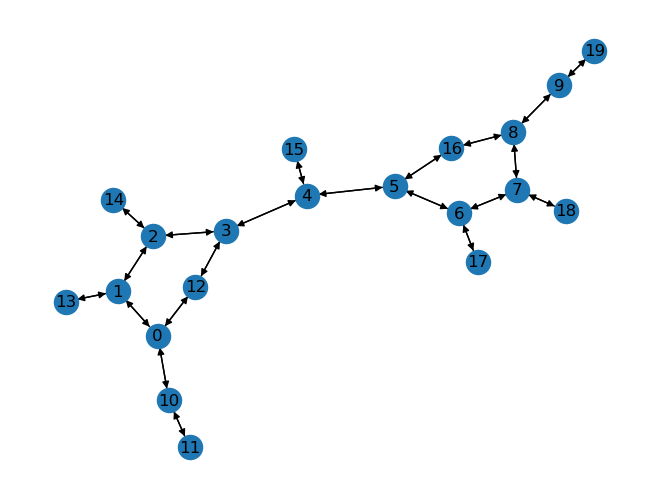

In [9]:
nx.draw(mol_batch[0].mol_tree,with_labels=True)

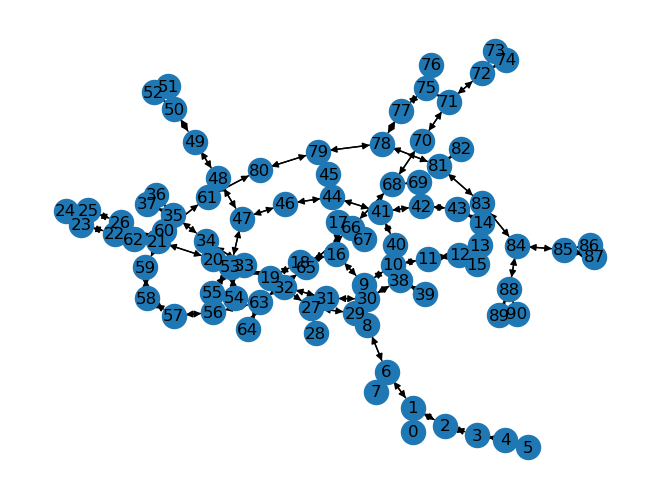

In [10]:
nx.draw(mol_batch[0].mol_graph,with_labels=True)

In [11]:
mol_batch[0].clusters

[(17, 16, 9, 8, 6),
 (28, 27, 19, 18, 16),
 (39, 38, 30, 29, 27),
 (45, 44, 41, 40, 38),
 (54, 53, 47, 46, 44),
 (64, 63, 56, 55, 53),
 (69, 68, 66, 65, 63),
 (76, 75, 71, 70, 68),
 (82, 81, 78, 77, 75),
 (81, 83, 84, 88, 89, 90),
 (0, 1, 6, 7),
 (2, 1, 3, 4, 5),
 (10, 9, 11, 12, 13, 14, 15, 43, 42, 41),
 (20, 19, 21, 22, 26, 23, 25, 24),
 (31, 30, 32, 33, 34, 35, 36, 37),
 (48, 47, 49, 50, 51, 52),
 (57, 56, 58, 59, 60, 61, 62, 80, 79, 78),
 (67, 66),
 (72, 71, 73, 74),
 (85, 84, 86, 87)]

In [12]:
test_tensor = tensorize(batches[0],vocab,max_span_tree=False)
#test_tensor[0] is two graphs, neither of which corresponds to the molecule in atoms or clusters
#test_tensor[1][0] is 6 arrays.
    #0:
    #1: edges of the clusters graph, with all cluster indices + 1. 
    #   the first column is first node, second column is second node.
    #   the third column is how many times one of the nodes has been visited (?)
    #   the fourth column is all zeros
    #2:
    #3:
    #4: atoms of each cluster, padded with 0's. all atom indices + 1. first row is all 0's
    #5: number of clusters + 1
#test_tensor[2] is the order from label_tree()

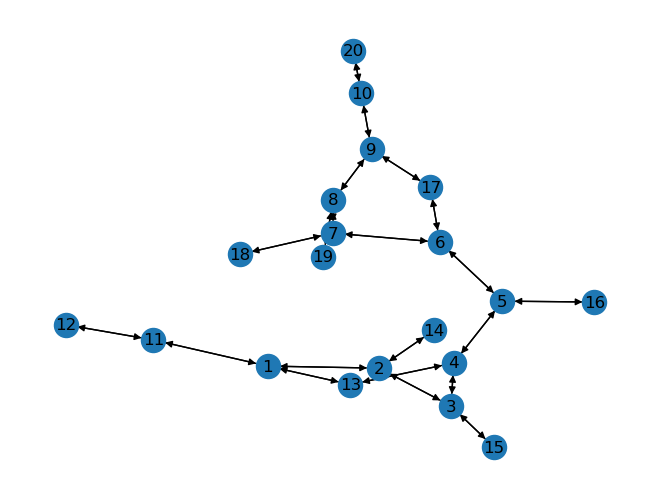

In [22]:
nx.draw(test_tensor[0][0],with_labels=True)

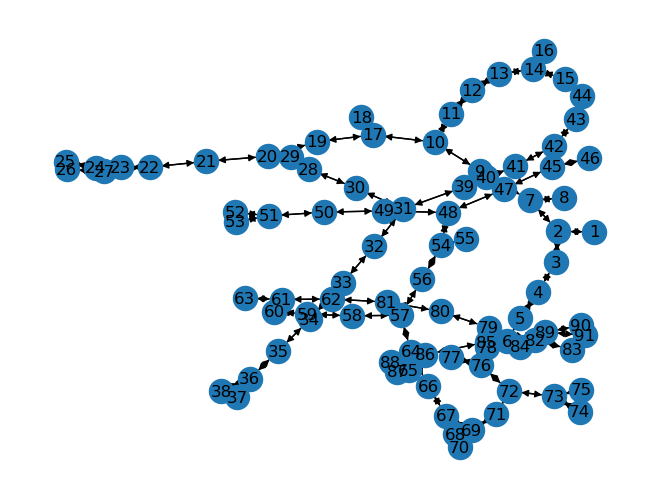

In [23]:
nx.draw(test_tensor[0][1],with_labels=True)

In [14]:
tensor_graph = MolGraph.tensorize_graph([x.mol_tree for x in mol_batch], vocab)

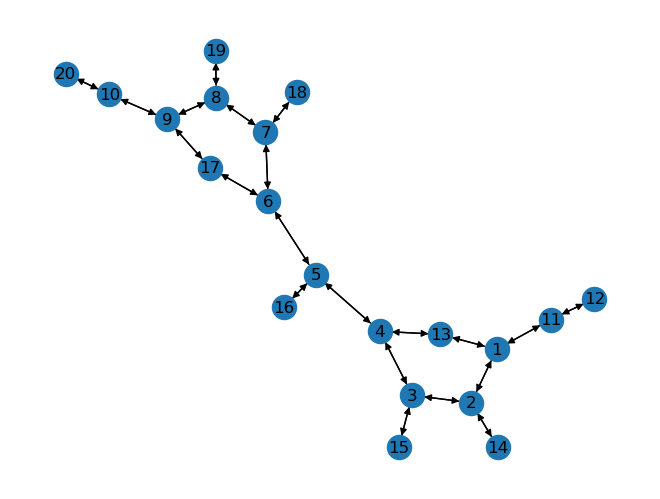

In [15]:
nx.draw(tensor_graph[1],with_labels=True)